In [151]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Completeness Data

MISSING VALUES (%)

cycles.csv
id                         0.000000
pond_id                    0.000000
species_id                31.104318
total_seed                 0.000000
started_at                 0.000000
finished_at                0.038212
remark                    48.949178
created_at                 0.000000
updated_at                 0.000000
area                       0.000000
initial_age                1.834161
limit_weight_per_area      0.267482
target_cultivation_day     0.114635
target_size                0.152847
extracted_at               0.000000
subscription_type          0.000000
ordered_at                58.196408
hatchery_id               17.768437
total_seed_type            9.247230
hatchery_name             17.768437
pond_name                  0.000000
pond_length                0.229270
pond_width                 0.229270
pond_depth                 4.508980
dtype: float64



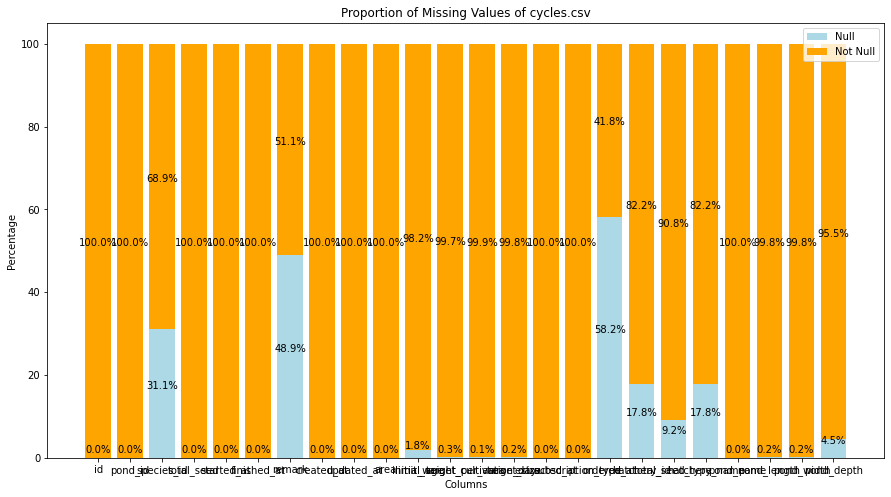

farms.csv
id           0.000000
province    13.067151
regency     16.878403
timezone     0.000000
dtype: float64



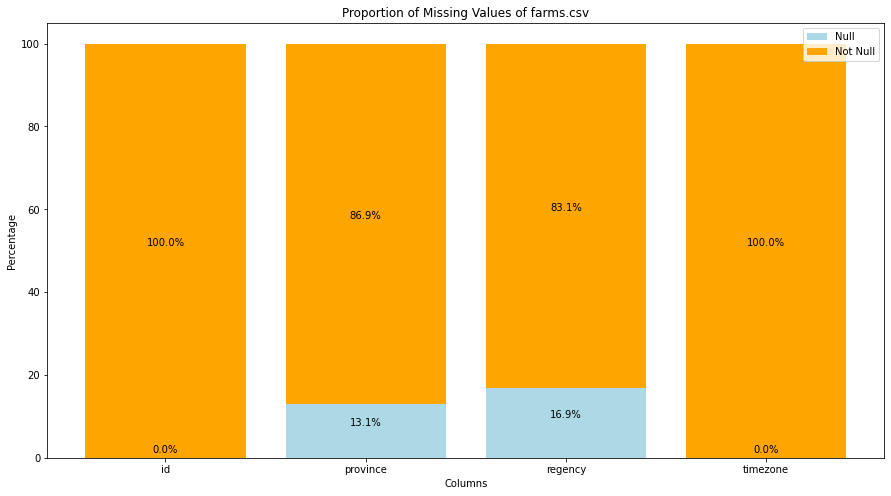

fasting.csv
logged_date    0.000000
cycle_id       0.000000
fasting        0.274681
dtype: float64



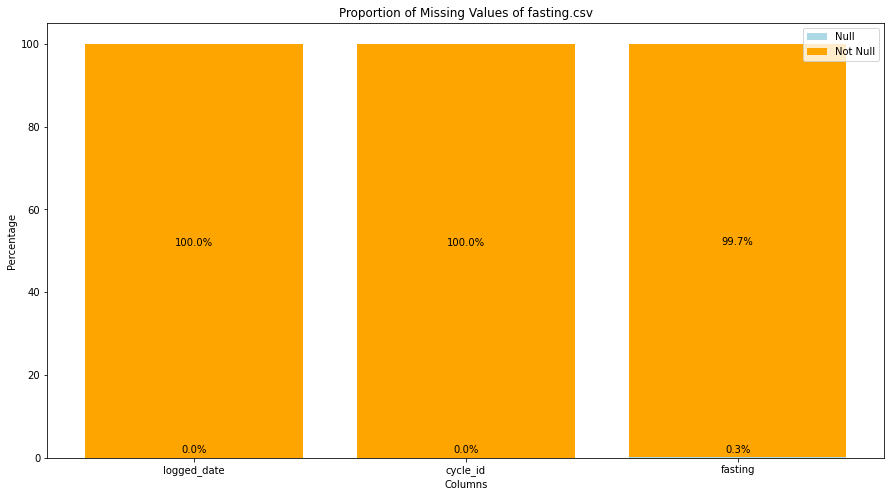

fastings.csv
logged_date    0.000000
cycle_id       0.000000
fasting        0.123537
dtype: float64



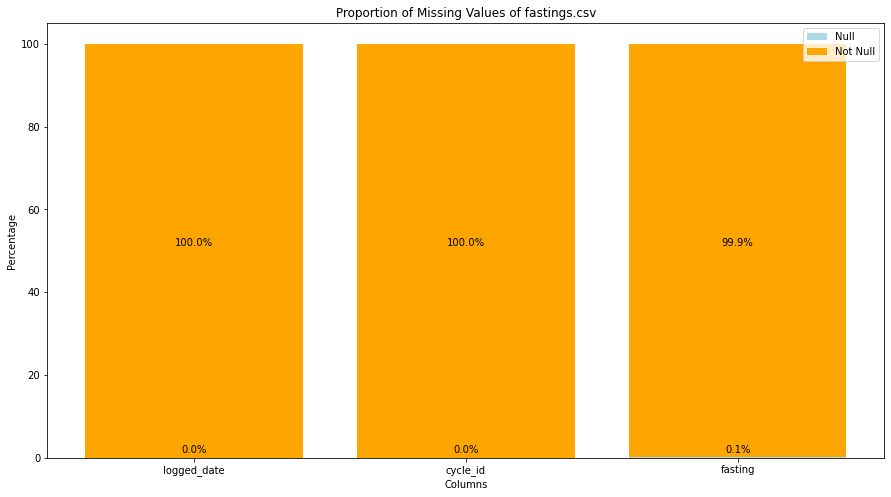

feeds.csv
cycle_id     0.000000
logged_at    0.002971
quantity     0.002971
dtype: float64



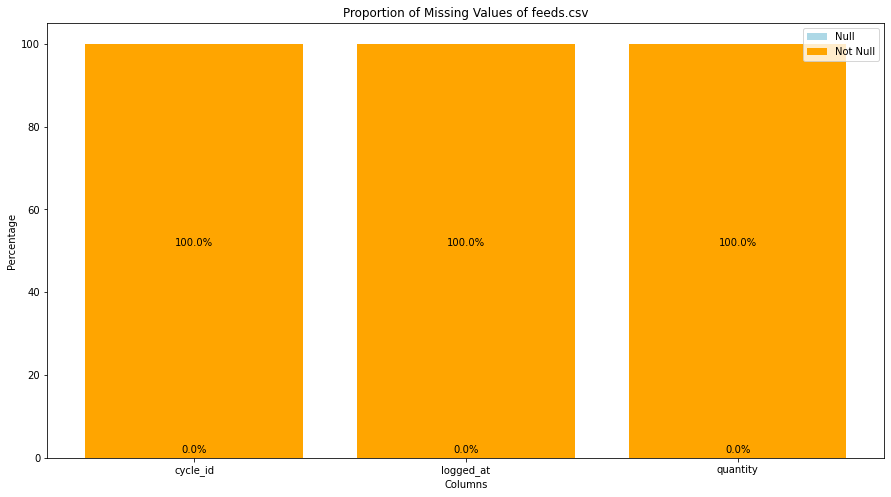

feed_tray.csv
id                         0.000000
logged_at                  0.000000
feed_logged_at             0.000000
cycle_id                   0.000000
tray_number                0.000000
feed_remaining_percent     0.000000
remark                    75.152681
created_at                 0.000000
updated_at                 0.000000
local_feed_logged_at       0.000000
dtype: float64



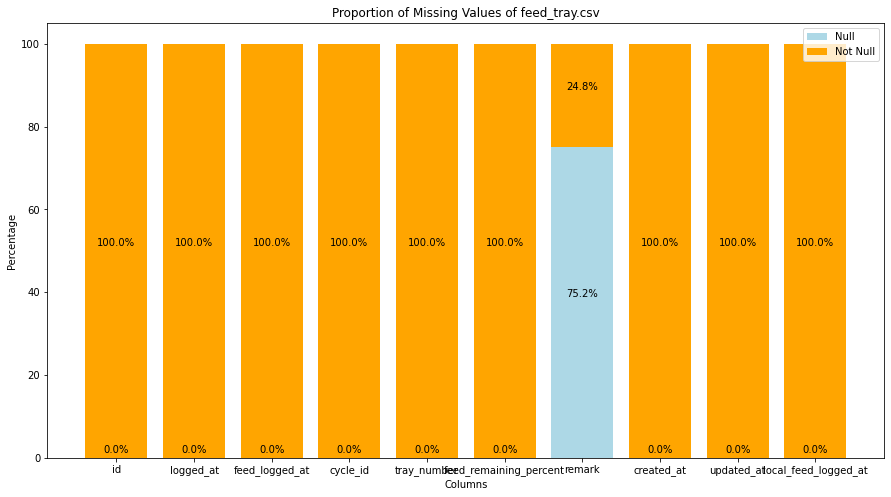

harvests.csv
cycle_id          0.000000
updated_at        0.000000
size              0.000000
created_at        0.000000
weight            0.000000
id                0.000000
harvested_at      0.000000
status            3.252133
selling_price    22.171386
dtype: float64



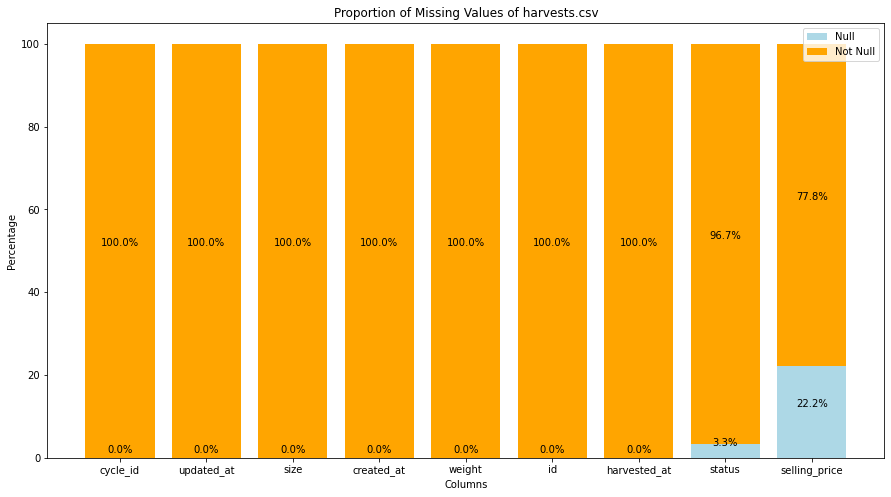

measurements.csv
pond_id                 0.000000
cycle_id                0.000000
measured_date           0.000000
morning_temperature    30.100683
evening_temperature    35.842503
morning_do             44.102122
evening_do             46.816253
morning_salinity       33.360662
evening_salinity       53.187343
morning_pH             14.466019
evening_pH             56.167566
transparency           44.408486
turbidity              99.880618
ammonia                97.304567
nitrate                98.445164
nitrite                92.983100
alkalinity             90.279036
hardness               96.026609
calcium                95.259259
magnesium              95.239123
carbonate              96.197051
bicarbonate            95.197411
tom                    94.767350
total_plankton_        90.923409
dtype: float64



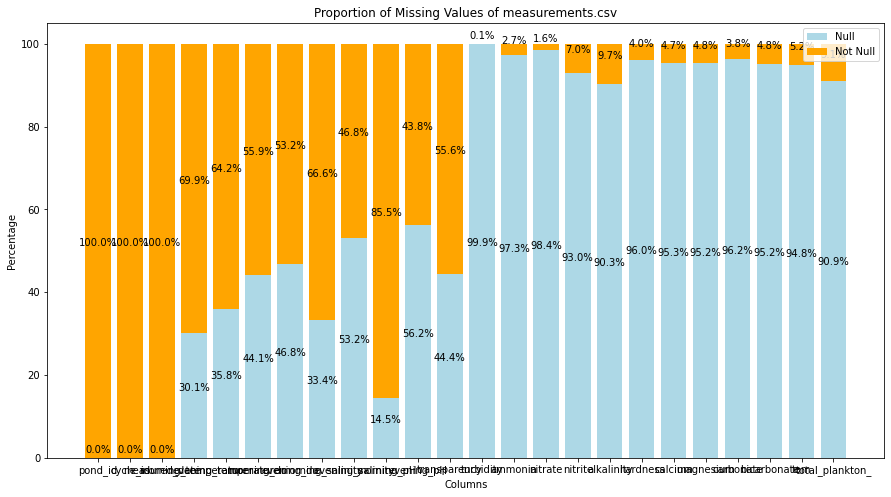

mortalities.csv
id                0.0
cycle_id          0.0
quantity          0.0
recorded_at       0.0
created_at        0.0
updated_at        0.0
average_weight    0.0
dtype: float64



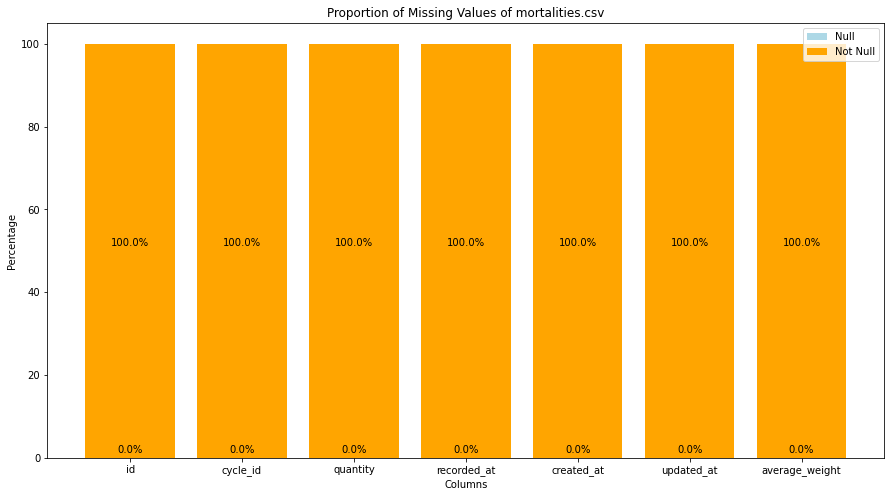

ponds.csv
id                   0.000000
farm_id              0.000000
length               6.804734
width                8.579882
deep                27.218935
created_at           0.000000
updated_at           0.000000
record_id            0.000000
extracted_at         0.000000
max_seed_density    60.059172
dtype: float64



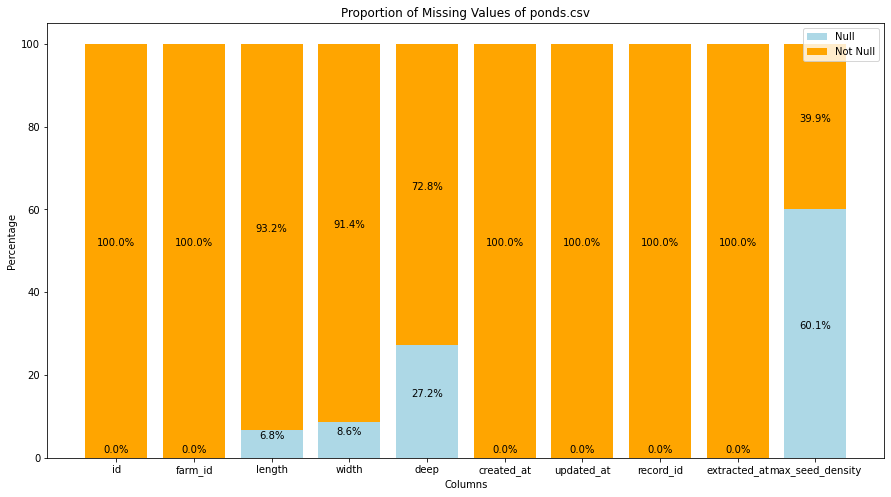

samplings.csv
cycle_id           0.000000
updated_at         0.000000
sampled_at         0.000000
created_at         0.000000
average_weight     0.000000
id                 0.000000
remark            91.092336
dtype: float64



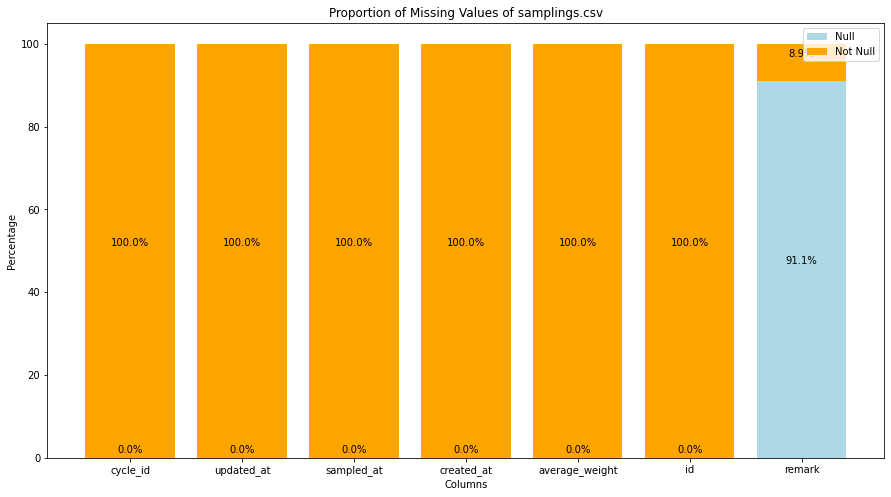

In [69]:
# missing values
print("MISSING VALUES (%)")
print('')
for file in os.listdir("./data"):
    data = pd.read_csv(f"./data/{file}")
    missing_values = data.isnull().sum()
    percent = (missing_values / data.shape[0])*100
    print(file)
    print(percent)
    print('')
    
    # VISUALIZE
    categories = percent.keys()
    my_list = [100 for _ in range(len(percent))]

    # Calculate percentages
    percentages1 = percent.values
    percentages2 = np.array(my_list) - np.array(percent.values)

    # Create percentage chart
    plt.figure(figsize=(15, 8))
    bars1 = plt.bar(categories, percentages1, label='Null', color='lightblue')
    bars2 = plt.bar(categories, percentages2, bottom=percentages1, label='Not Null', color='orange')
    plt.xlabel('Columns')
    plt.ylabel('Percentage')
    plt.title(f'Proportion of Missing Values of {file}')
    plt.legend()

    # Annotate each bar with its percentage value
    i=0
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if i==0:
                plt.annotate(f'{height:.1f}%', 
                             xy=(bar.get_x() + bar.get_width() / 2, height/2),
                             xytext=(0, 3),  
                             textcoords="offset points",
                             ha='center', va='bottom')
            else:
                plt.annotate(f'{height:.1f}%', 
                             xy=(bar.get_x() + bar.get_width() / 2, ((100-height)+(height/2))),
                             xytext=(0, 3),  
                             textcoords="offset points",
                             ha='center', va='bottom')
        i+=1

    plt.show()

NOTE:
Beberapa data terdapat NULL VALUES, Tetapi column yang memiliki banyak NULL VALUES adalah column yang bukan dipakai untuk analisis, sehingga data ini masih bisa dipakai untuk analisis. Jika ada column yang dipakai untuk analisis memiliki banyak null values maka harus dilakukan sesuatu untuk menghandle null value tersebut

# Calculate SR and ADG

### SR

In [154]:
df1 = pd.read_csv("./data/cycles.csv").drop_duplicates()
df2 = pd.read_csv("./data/harvests.csv").drop_duplicates()

In [155]:
df1_new = df1[['id','total_seed']]
df2_new = df2[['cycle_id','size','weight']]

df1_new = df1_new.rename({'id':'cycle_id'}, axis=1)

df_merge = df1_new.merge(df2_new, on='cycle_id')
df_merge

,cycle_id,total_seed,size,weight
0,18876,331920,83.00,1735.50
1,18876,331920,100.00,118.00
2,22118,40000,110.00,200.00
3,22118,40000,110.00,70.00
4,24088,357570,72.48,934.38
...,...,...,...,...
8299,15868,150000,190.00,288.71
8300,15868,150000,200.00,90.00
8301,20849,384000,105.00,2447.07
8302,20849,384000,163.00,194.60


In [156]:
# harvested shrimp
df_merge['harvested'] = df_merge['size'] * df_merge['weight']

# Survival Rate (SR)
df_merge['SR'] = (df_merge['harvested'] / df_merge['total_seed']) * 100

df_merge

,cycle_id,total_seed,size,weight,harvested,SR
0,18876,331920,83.00,1735.50,144046.5000,43.397957
1,18876,331920,100.00,118.00,11800.0000,3.555074
2,22118,40000,110.00,200.00,22000.0000,55.000000
3,22118,40000,110.00,70.00,7700.0000,19.250000
4,24088,357570,72.48,934.38,67723.8624,18.940029
...,...,...,...,...,...,...
8299,15868,150000,190.00,288.71,54854.9000,36.569933
8300,15868,150000,200.00,90.00,18000.0000,12.000000
8301,20849,384000,105.00,2447.07,256942.3500,66.912070
8302,20849,384000,163.00,194.60,31719.8000,8.260365


In [157]:
df_merge['SR'].mean()

94.68948560590212

In [158]:
df_merge.to_csv("survival_rate.csv", index=False)

Rata-rata untuk Survival Rate nya adalah sekitar 94,7%

### ADG

In [205]:
df = pd.read_csv("./data/samplings.csv",
                  parse_dates=['updated_at','sampled_at','created_at'])
df = df.drop_duplicates()
df = df.sort_values(['cycle_id','sampled_at'])
df

,cycle_id,updated_at,sampled_at,created_at,average_weight,id,remark
8745,3458.0,2020-05-03 03:27:58,2020-04-10,2020-05-03 03:27:58,4.37,5310.0,NaN
8746,3458.0,2020-05-03 03:28:22,2020-04-17,2020-05-03 03:28:22,5.23,5311.0,NaN
8744,3458.0,2020-05-02 14:17:23,2020-04-24,2020-05-02 14:17:23,6.69,5309.0,NaN
8743,3458.0,2020-05-02 14:16:40,2020-05-01,2020-05-02 14:16:40,8.21,5308.0,NaN
8747,3458.0,2020-05-08 01:59:49,2020-05-08,2020-05-08 01:59:49,9.68,5361.0,NaN
...,...,...,...,...,...,...,...
5770,29874.0,2024-04-03 05:23:35,2024-02-20,2024-04-03 05:23:35,4.10,61741.0,NaN
5771,29874.0,2024-04-03 05:24:09,2024-02-27,2024-04-03 05:24:09,6.20,61742.0,NaN
5772,29874.0,2024-04-03 05:24:41,2024-03-05,2024-04-03 05:24:41,8.39,61743.0,NaN
5773,29874.0,2024-04-03 05:25:11,2024-03-12,2024-04-03 05:25:11,8.98,61744.0,NaN


In [206]:
list_cycle = df['cycle_id'].to_list()
list_date = df['sampled_at'].to_list()
list_weight = df['average_weight'].to_list()

list_days = []
list_diff_weight = []
cycle_before = 0
for i, cycle in enumerate(list_cycle):
    if cycle == cycle_before:
        long_days = (list_date[i] - list_date[i-1]).days
        diff_weight = list_weight[i] - list_weight[i-1]
    else:
        long_days = np.nan
        diff_weight = np.nan
    
    list_days.append(long_days)
    list_diff_weight.append(diff_weight)
    
    cycle_before = cycle

In [207]:
df['long_days'] = list_days
df['diff_weight'] = list_diff_weight
df['ADG'] = df['diff_weight'] / df['long_days']
df

,cycle_id,updated_at,sampled_at,created_at,average_weight,id,remark,long_days,diff_weight,ADG
8745,3458.0,2020-05-03 03:27:58,2020-04-10,2020-05-03 03:27:58,4.37,5310.0,NaN,NaN,NaN,NaN
8746,3458.0,2020-05-03 03:28:22,2020-04-17,2020-05-03 03:28:22,5.23,5311.0,NaN,7.0,0.86,0.122857
8744,3458.0,2020-05-02 14:17:23,2020-04-24,2020-05-02 14:17:23,6.69,5309.0,NaN,7.0,1.46,0.208571
8743,3458.0,2020-05-02 14:16:40,2020-05-01,2020-05-02 14:16:40,8.21,5308.0,NaN,7.0,1.52,0.217143
8747,3458.0,2020-05-08 01:59:49,2020-05-08,2020-05-08 01:59:49,9.68,5361.0,NaN,7.0,1.47,0.210000
...,...,...,...,...,...,...,...,...,...,...
5770,29874.0,2024-04-03 05:23:35,2024-02-20,2024-04-03 05:23:35,4.10,61741.0,NaN,7.0,1.13,0.161429
5771,29874.0,2024-04-03 05:24:09,2024-02-27,2024-04-03 05:24:09,6.20,61742.0,NaN,7.0,2.10,0.300000
5772,29874.0,2024-04-03 05:24:41,2024-03-05,2024-04-03 05:24:41,8.39,61743.0,NaN,7.0,2.19,0.312857
5773,29874.0,2024-04-03 05:25:11,2024-03-12,2024-04-03 05:25:11,8.98,61744.0,NaN,7.0,0.59,0.084286


In [208]:
filtered_data = df[~df.isin([np.inf, -np.inf]).any(axis=1)]
filtered_data

,cycle_id,updated_at,sampled_at,created_at,average_weight,id,remark,long_days,diff_weight,ADG
8745,3458.0,2020-05-03 03:27:58,2020-04-10,2020-05-03 03:27:58,4.37,5310.0,NaN,NaN,NaN,NaN
8746,3458.0,2020-05-03 03:28:22,2020-04-17,2020-05-03 03:28:22,5.23,5311.0,NaN,7.0,0.86,0.122857
8744,3458.0,2020-05-02 14:17:23,2020-04-24,2020-05-02 14:17:23,6.69,5309.0,NaN,7.0,1.46,0.208571
8743,3458.0,2020-05-02 14:16:40,2020-05-01,2020-05-02 14:16:40,8.21,5308.0,NaN,7.0,1.52,0.217143
8747,3458.0,2020-05-08 01:59:49,2020-05-08,2020-05-08 01:59:49,9.68,5361.0,NaN,7.0,1.47,0.210000
...,...,...,...,...,...,...,...,...,...,...
5770,29874.0,2024-04-03 05:23:35,2024-02-20,2024-04-03 05:23:35,4.10,61741.0,NaN,7.0,1.13,0.161429
5771,29874.0,2024-04-03 05:24:09,2024-02-27,2024-04-03 05:24:09,6.20,61742.0,NaN,7.0,2.10,0.300000
5772,29874.0,2024-04-03 05:24:41,2024-03-05,2024-04-03 05:24:41,8.39,61743.0,NaN,7.0,2.19,0.312857
5773,29874.0,2024-04-03 05:25:11,2024-03-12,2024-04-03 05:25:11,8.98,61744.0,NaN,7.0,0.59,0.084286


In [210]:
filtered_data.to_csv("average_daily_growth.csv", index=False)

In [209]:
filtered_data['ADG'].mean()

0.25592440211240236

Rata-rata untuk seluruh ADG adalah sekitar 0.25 grams

# SR forecast

In [161]:
df = pd.read_csv('survival_rate.csv')
df1 = pd.read_csv('./data/cycles.csv')
df

,cycle_id,total_seed,size,weight,harvested,SR
0,18876,331920,83.00,1735.50,144046.5000,43.397957
1,18876,331920,100.00,118.00,11800.0000,3.555074
2,22118,40000,110.00,200.00,22000.0000,55.000000
3,22118,40000,110.00,70.00,7700.0000,19.250000
4,24088,357570,72.48,934.38,67723.8624,18.940029
...,...,...,...,...,...,...
8299,15868,150000,190.00,288.71,54854.9000,36.569933
8300,15868,150000,200.00,90.00,18000.0000,12.000000
8301,20849,384000,105.00,2447.07,256942.3500,66.912070
8302,20849,384000,163.00,194.60,31719.8000,8.260365


In [177]:
df1_new = df1[['id','finished_at']]
df1_new = df1_new.rename({'id':'cycle_id'}, axis=1)

df_merge = df.merge(df1_new, on='cycle_id')[['finished_at','SR']]
df_merge['finished_at'] = pd.to_datetime(df_merge['finished_at'])
df_merge = df_merge.sort_values('finished_at')
df_merge

,finished_at,SR
4776,2020-05-20,55.065312
4777,2020-05-20,34.542816
945,2020-06-01,100.500000
9047,2020-06-02,78.222222
4042,2020-06-07,2.841700
...,...,...
1907,2024-04-02,2.771552
1908,2024-04-02,38.684318
6019,2024-04-02,26.493273
6016,2024-04-02,24.762058


C:\Users\prase\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\prase\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\prase\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Forecasted Survival Rate for 2024-05-01: 82.47%


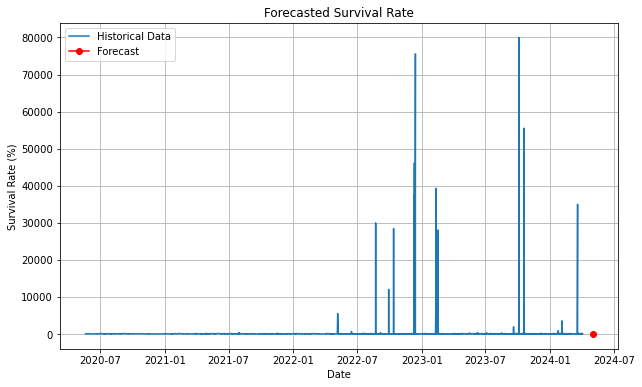

In [179]:
data = df_merge.copy()

# Train SARIMA model
order = (1, 1, 1)
model = SARIMAX(data['SR'], order=order)
results = model.fit()

# Forecast survival rate for a specific day (e.g., end of cultivation)
forecast_day = pd.to_datetime('2024-05-01')
forecast = results.get_forecast(steps=1)
forecasted_survival_rate = forecast.predicted_mean.values[0]

print("Forecasted Survival Rate for {}: {:.2f}%".format(forecast_day.date(), forecasted_survival_rate))

# Plotting forecasted survival rate
plt.figure(figsize=(10, 6))
plt.plot(data['finished_at'], data['SR'], label='Historical Data')
plt.plot([forecast_day], [forecasted_survival_rate], marker='o', color='red', label='Forecast')
plt.title('Forecasted Survival Rate')
plt.xlabel('Date')
plt.ylabel('Survival Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

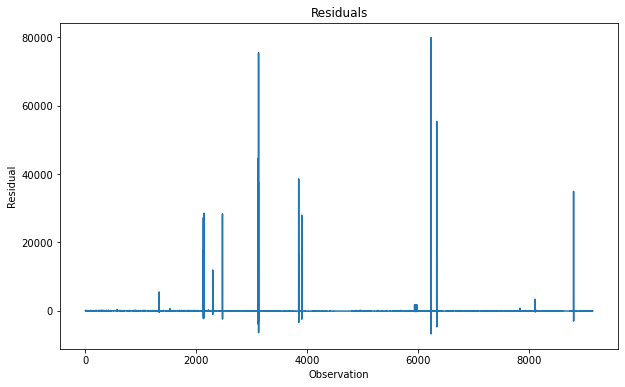

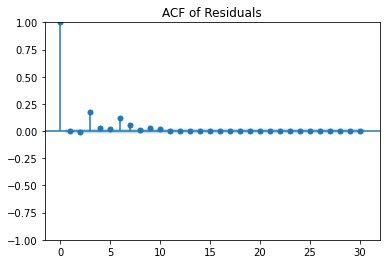

C:\Users\prase\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


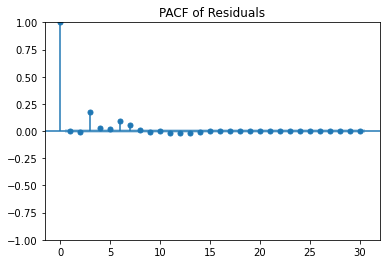

                               SARIMAX Results                                
Dep. Variable:                     SR   No. Observations:                 9149
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -81038.127
Date:                Mon, 22 Apr 2024   AIC                         162082.255
Time:                        23:41:02   BIC                         162103.619
Sample:                             0   HQIC                        162089.518
                               - 9149                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0840      0.002     39.963      0.000       0.080       0.088
ma.L1         -1.0000      0.001  -1653.276      0.000      -1.001      -0.999
sigma2      2.895e+06   2.09e-10   1.38e+16      0.0

In [183]:
# Residual Analysis
residuals = results.resid
residuals = residuals.reset_index(drop=True)
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.xlabel('Observation')
plt.ylabel('Residual')
plt.show()

# ACF and PACF plots of residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals, lags=30)
plt.title('ACF of Residuals')
plt.show()
plot_pacf(residuals, lags=30)
plt.title('PACF of Residuals')
plt.show()

# Diagnostic Summary
print(results.summary())

# Forecast Accuracy Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error:", mean_absolute_error(data['SR'], results.fittedvalues))
print("Mean Squared Error:", mean_squared_error(data['SR'], results.fittedvalues))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(data['SR'], results.fittedvalues)))

# Information Criteria
print("AIC:", results.aic)
print("BIC:", results.bic)

# Average Body Weight forecast

In [184]:
df = pd.read_csv('./data/samplings.csv')
df

,cycle_id,updated_at,sampled_at,created_at,average_weight,id,remark
0,18747.0,2022-10-07 03:26:30,2022-09-24,2022-10-07 02:10:49,4.91,32508.0,Size 204\nP/H = 99 kg\nP/K = 2.020 kg\nSamplin...
1,18747.0,2022-10-07 03:27:27,2022-10-01,2022-10-07 03:27:27,7.12,32534.0,"Size 140\nADG = 0,31\nP/H = 139 kg\nP/K = 2.88..."
2,18747.0,2022-10-08 01:30:56,2022-10-08,2022-10-08 01:30:56,9.75,32575.0,"Size 103\nADG = 0,38\nP/H = 160 kg\nP/K = 3.94..."
3,18747.0,2022-10-15 03:24:26,2022-10-15,2022-10-15 03:24:26,11.15,32864.0,"Size 90\nADG 0,23\nP/H = 180 kg\nP/K = 5.149 k..."
4,27095.0,2023-11-05 09:03:39,2023-10-07,2023-11-05 09:03:39,4.79,52037.0,NaN
...,...,...,...,...,...,...,...
15027,11741.0,2021-11-13 02:38:57,2021-11-10,2021-11-13 02:38:57,11.14,20247.0,NaN
15028,11741.0,2021-11-18 12:49:02,2021-11-17,2021-11-18 12:49:02,11.38,20579.0,NaN
15029,24650.0,2023-09-07 23:59:57,2023-09-08,2023-09-07 23:59:57,3.41,47154.0,size 293
15030,24650.0,2023-09-15 00:15:13,2023-09-15,2023-09-15 00:15:13,3.48,47603.0,size 287


In [186]:
df_new = df[['sampled_at','average_weight']]
df_new['sampled_at'] = pd.to_datetime(df_new['sampled_at'])
df_new = df_new.sort_values('sampled_at')
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop(0)
df_new

C:\Users\prase\AppData\Local\Temp\ipykernel_28920\1905227482.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['sampled_at'] = pd.to_datetime(df_new['sampled_at'])


,sampled_at,average_weight
1,2020-01-26,8.86
2,2020-04-10,4.18
3,2020-04-10,4.37
4,2020-04-17,4.95
5,2020-04-17,5.23
...,...,...
15027,2024-03-30,7.14
15028,2024-03-30,9.34
15029,2024-04-01,6.66
15030,2024-04-02,7.40


Forecasted Average Weight for 2024-05-01: 12.36


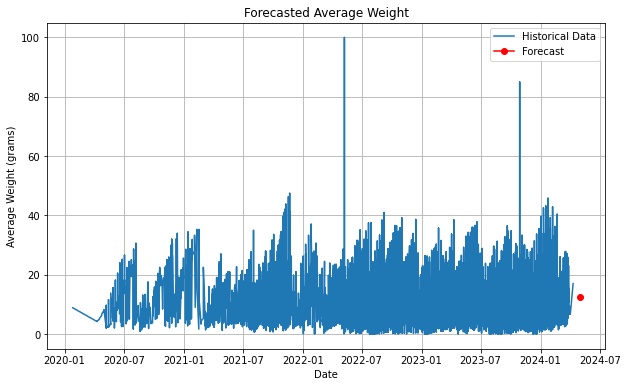

In [189]:
data = df_new.copy()

# Train SARIMA model
order = (1, 1, 1)
model = SARIMAX(data['average_weight'], order=order)
results = model.fit()

# Forecast survival rate for a specific day (e.g., end of cultivation)
forecast_day = pd.to_datetime('2024-05-01')
forecast = results.get_forecast(steps=1)
forecasted_survival_rate = forecast.predicted_mean.values[0]

print("Forecasted Average Weight for {}: {:.2f}".format(forecast_day.date(), forecasted_survival_rate))

# Plotting forecasted survival rate
plt.figure(figsize=(10, 6))
plt.plot(data['sampled_at'], data['average_weight'], label='Historical Data')
plt.plot([forecast_day], [forecasted_survival_rate], marker='o', color='red', label='Forecast')
plt.title('Forecasted Average Weight')
plt.xlabel('Date')
plt.ylabel('Average Weight (grams)')
plt.legend()
plt.grid(True)
plt.show()

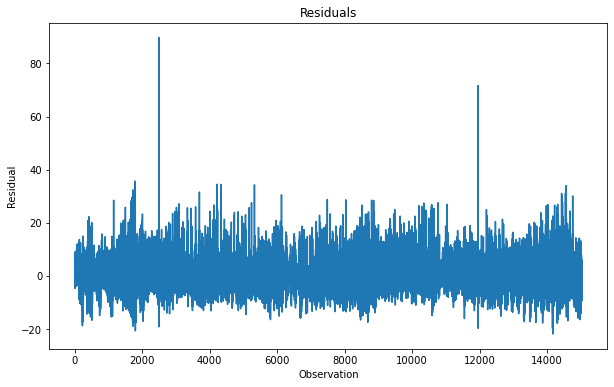

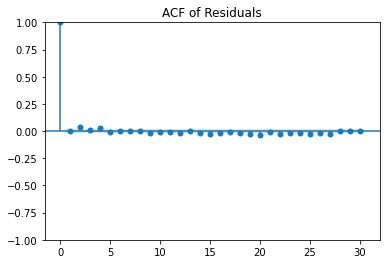

C:\Users\prase\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


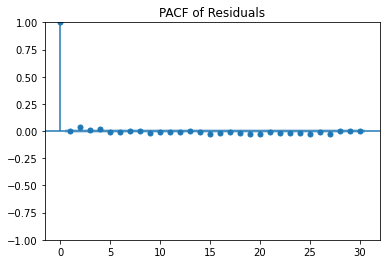

                               SARIMAX Results                                
Dep. Variable:         average_weight   No. Observations:                15031
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -50039.752
Date:                Mon, 22 Apr 2024   AIC                         100085.503
Time:                        23:50:10   BIC                         100108.357
Sample:                             0   HQIC                        100093.085
                              - 15031                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0679      0.007      9.435      0.000       0.054       0.082
ma.L1         -0.8981      0.004   -252.451      0.000      -0.905      -0.891
sigma2        45.6349      0.299    152.766      0.0

In [190]:
# Residual Analysis
residuals = results.resid
residuals = residuals.reset_index(drop=True)
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.xlabel('Observation')
plt.ylabel('Residual')
plt.show()

# ACF and PACF plots of residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals, lags=30)
plt.title('ACF of Residuals')
plt.show()
plot_pacf(residuals, lags=30)
plt.title('PACF of Residuals')
plt.show()

# Diagnostic Summary
print(results.summary())

# Forecast Accuracy Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error:", mean_absolute_error(data['average_weight'], results.fittedvalues))
print("Mean Squared Error:", mean_squared_error(data['average_weight'], results.fittedvalues))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(data['average_weight'], results.fittedvalues)))

# Information Criteria
print("AIC:", results.aic)
print("BIC:", results.bic)

# Biomass forecast

In [191]:
df = pd.read_csv('./data/harvests.csv')
df

,cycle_id,updated_at,size,created_at,weight,id,harvested_at,status,selling_price
0,15013.0,2022-07-18 08:42:59,399.86,2022-07-18 08:42:59,0.01,11960.0,2022-04-17,Failed,NaN
1,11848.0,2021-10-25 23:29:53,300.00,2021-10-24 08:38:53,46.00,7520.0,2021-10-22,Full,1610000.0
2,11848.0,2021-10-25 23:29:35,300.00,2021-10-25 23:29:35,10.00,7546.0,2021-10-21,Partial,350000.0
3,4666.0,2020-10-08 02:07:18,110.00,2020-10-08 02:07:18,270.50,3009.0,2020-08-31,Failed,NaN
4,4666.0,2020-10-08 02:07:37,190.00,2020-10-08 02:07:37,270.50,3010.0,2020-08-31,Failed,NaN
...,...,...,...,...,...,...,...,...,...
8082,28500.0,2024-03-17 06:34:46,90.00,2024-03-14 05:43:03,12.00,27731.0,2024-03-05,Full,720000.0
8083,28500.0,2024-03-17 06:31:41,150.00,2024-03-14 05:47:06,4.00,27732.0,2024-02-02,Partial,280000.0
8084,11741.0,2022-10-06 05:23:38,80.00,2021-11-22 05:44:13,183.00,8252.0,2021-11-20,Full,10431000.0
8085,11741.0,2022-10-06 05:23:39,80.00,2021-11-22 05:55:49,30.00,8254.0,2021-11-20,Partial,1200000.0


In [192]:
df_new = df[['harvested_at','weight']]
df_new['harvested_at'] = pd.to_datetime(df_new['harvested_at'])
df_new = df_new.sort_values('harvested_at')
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop(0)
df_new

C:\Users\prase\AppData\Local\Temp\ipykernel_28920\156593761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['harvested_at'] = pd.to_datetime(df_new['harvested_at'])


,harvested_at,weight
1,2020-05-13,1576.46
2,2020-05-13,1643.13
3,2020-05-17,170.00
4,2020-05-20,271.00
5,2020-05-26,1550.00
...,...,...
8082,2024-04-02,812.00
8083,2024-04-02,500.00
8084,2024-04-02,3189.67
8085,2024-04-02,691.00


Forecasted Biomass for 2024-05-01: 764.05


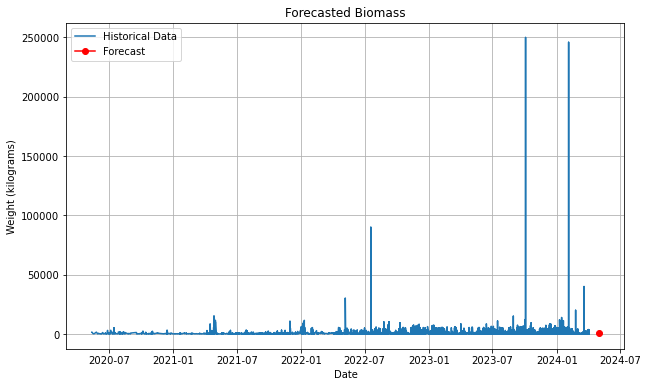

In [193]:
data = df_new.copy()

# Train SARIMA model
order = (1, 1, 1)
model = SARIMAX(data['weight'], order=order)
results = model.fit()

# Forecast survival rate for a specific day (e.g., end of cultivation)
forecast_day = pd.to_datetime('2024-05-01')
forecast = results.get_forecast(steps=1)
forecasted_survival_rate = forecast.predicted_mean.values[0]

print("Forecasted Biomass for {}: {:.2f}".format(forecast_day.date(), forecasted_survival_rate))

# Plotting forecasted survival rate
plt.figure(figsize=(10, 6))
plt.plot(data['harvested_at'], data['weight'], label='Historical Data')
plt.plot([forecast_day], [forecasted_survival_rate], marker='o', color='red', label='Forecast')
plt.title('Forecasted Biomass')
plt.xlabel('Date')
plt.ylabel('Weight (kilograms)')
plt.legend()
plt.grid(True)
plt.show()

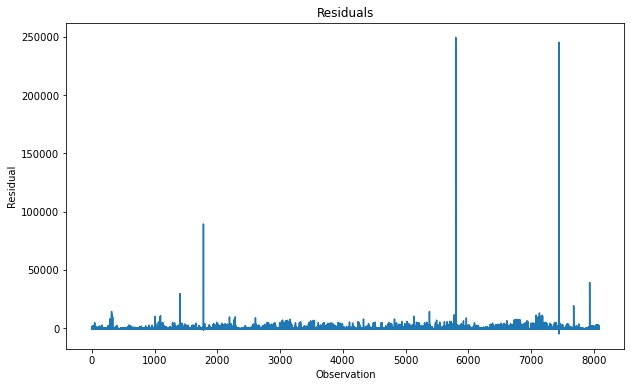

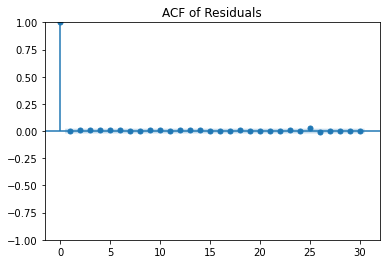

C:\Users\prase\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


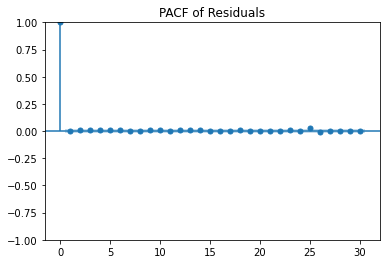

                               SARIMAX Results                                
Dep. Variable:                 weight   No. Observations:                 8086
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -79054.916
Date:                Tue, 23 Apr 2024   AIC                         158115.833
Time:                        00:35:31   BIC                         158136.826
Sample:                             0   HQIC                        158123.015
                               - 8086                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0171      0.014      1.216      0.224      -0.010       0.045
ma.L1         -1.0000      0.000  -2331.234      0.000      -1.001      -0.999
sigma2      1.821e+07   2.74e-11   6.63e+17      0.0

In [194]:
# Residual Analysis
residuals = results.resid
residuals = residuals.reset_index(drop=True)
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.xlabel('Observation')
plt.ylabel('Residual')
plt.show()

# ACF and PACF plots of residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals, lags=30)
plt.title('ACF of Residuals')
plt.show()
plot_pacf(residuals, lags=30)
plt.title('PACF of Residuals')
plt.show()

# Diagnostic Summary
print(results.summary())

# Forecast Accuracy Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error:", mean_absolute_error(data['weight'], results.fittedvalues))
print("Mean Squared Error:", mean_squared_error(data['weight'], results.fittedvalues))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(data['weight'], results.fittedvalues)))

# Information Criteria
print("AIC:", results.aic)
print("BIC:", results.bic)

# Revenue forecast

In [196]:
df = pd.read_csv('./data/harvests.csv')
df

,cycle_id,updated_at,size,created_at,weight,id,harvested_at,status,selling_price
0,15013.0,2022-07-18 08:42:59,399.86,2022-07-18 08:42:59,0.01,11960.0,2022-04-17,Failed,NaN
1,11848.0,2021-10-25 23:29:53,300.00,2021-10-24 08:38:53,46.00,7520.0,2021-10-22,Full,1610000.0
2,11848.0,2021-10-25 23:29:35,300.00,2021-10-25 23:29:35,10.00,7546.0,2021-10-21,Partial,350000.0
3,4666.0,2020-10-08 02:07:18,110.00,2020-10-08 02:07:18,270.50,3009.0,2020-08-31,Failed,NaN
4,4666.0,2020-10-08 02:07:37,190.00,2020-10-08 02:07:37,270.50,3010.0,2020-08-31,Failed,NaN
...,...,...,...,...,...,...,...,...,...
8082,28500.0,2024-03-17 06:34:46,90.00,2024-03-14 05:43:03,12.00,27731.0,2024-03-05,Full,720000.0
8083,28500.0,2024-03-17 06:31:41,150.00,2024-03-14 05:47:06,4.00,27732.0,2024-02-02,Partial,280000.0
8084,11741.0,2022-10-06 05:23:38,80.00,2021-11-22 05:44:13,183.00,8252.0,2021-11-20,Full,10431000.0
8085,11741.0,2022-10-06 05:23:39,80.00,2021-11-22 05:55:49,30.00,8254.0,2021-11-20,Partial,1200000.0


In [201]:
df_new = df[['harvested_at','selling_price']]
df_new['harvested_at'] = pd.to_datetime(df_new['harvested_at'])
df_new = df_new.sort_values('harvested_at')
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop(0)
df_new = df_new.dropna()
df_new

C:\Users\prase\AppData\Local\Temp\ipykernel_28920\4154795175.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['harvested_at'] = pd.to_datetime(df_new['harvested_at'])


,harvested_at,selling_price
7,2020-05-30,2.301394e+06
8,2020-05-30,3.311665e+06
11,2020-06-07,0.000000e+00
12,2020-06-09,5.639868e+06
13,2020-06-09,1.563432e+07
...,...,...
8081,2024-04-02,1.116461e+08
8082,2024-04-02,4.969440e+07
8083,2024-04-02,3.550000e+04
8085,2024-04-02,3.924880e+07


C:\Users\prase\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\prase\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\prase\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Forecasted Revenue for 2024-05-01: 41102759.02


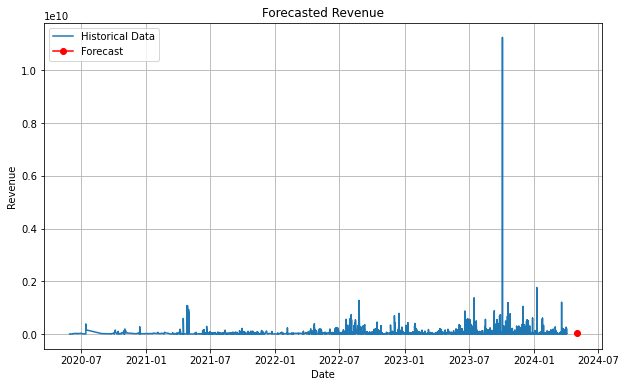

In [203]:
data = df_new.copy()

# Train SARIMA model
order = (1, 1, 1)
model = SARIMAX(data['selling_price'], order=order)
results = model.fit()

# Forecast survival rate for a specific day (e.g., end of cultivation)
forecast_day = pd.to_datetime('2024-05-01')
forecast = results.get_forecast(steps=1)
forecasted_survival_rate = forecast.predicted_mean.values[0]

print("Forecasted Revenue for {}: {:.2f}".format(forecast_day.date(), forecasted_survival_rate))

# Plotting forecasted survival rate
plt.figure(figsize=(10, 6))
plt.plot(data['harvested_at'], data['selling_price'], label='Historical Data')
plt.plot([forecast_day], [forecasted_survival_rate], marker='o', color='red', label='Forecast')
plt.title('Forecasted Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

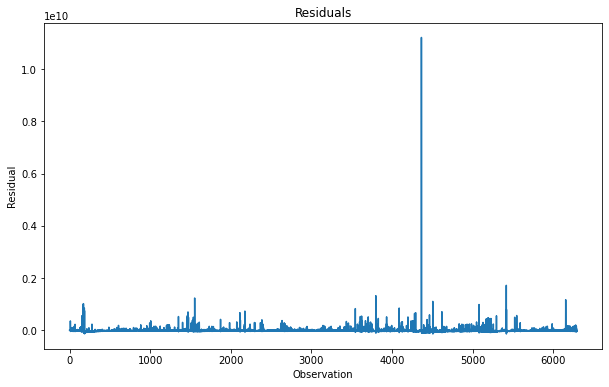

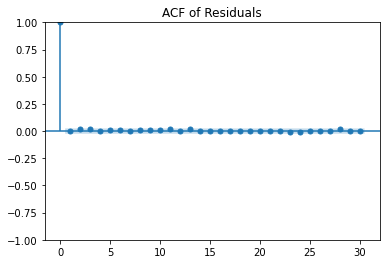

C:\Users\prase\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


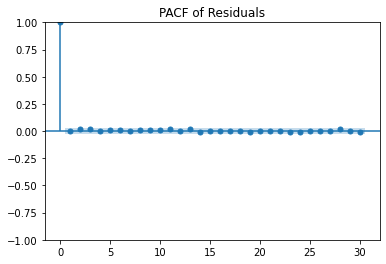

                               SARIMAX Results                                
Dep. Variable:          selling_price   No. Observations:                 6294
Model:               SARIMAX(1, 1, 1)   Log Likelihood             -128031.145
Date:                Tue, 23 Apr 2024   AIC                         256068.290
Time:                        00:39:34   BIC                         256088.531
Sample:                             0   HQIC                        256075.302
                               - 6294                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0544      0.020      2.731      0.006       0.015       0.094
ma.L1         -0.9944      0.003   -346.277      0.000      -1.000      -0.989
sigma2      3.296e+16   1.83e-19    1.8e+35      0.0

In [204]:
# Residual Analysis
residuals = results.resid
residuals = residuals.reset_index(drop=True)
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.xlabel('Observation')
plt.ylabel('Residual')
plt.show()

# ACF and PACF plots of residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals, lags=30)
plt.title('ACF of Residuals')
plt.show()
plot_pacf(residuals, lags=30)
plt.title('PACF of Residuals')
plt.show()

# Diagnostic Summary
print(results.summary())

# Forecast Accuracy Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error:", mean_absolute_error(data['selling_price'], results.fittedvalues))
print("Mean Squared Error:", mean_squared_error(data['selling_price'], results.fittedvalues))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(data['selling_price'], results.fittedvalues)))

# Information Criteria
print("AIC:", results.aic)
print("BIC:", results.bic)